# Infer ***mitochondria*** - part 3️⃣

--------------
## **OBJECTIVE**

### <input type="checkbox"/> Infer sub-cellular component  ***mitochondria***  
Segment the ***mitochondria*** from a single channel (inter mitochondrial membrane marker). This workflow was optimized for images of fluorescently tagged COX8 signal sequence which localizes to the inner mitochondrial membrane. Mitochondria size and shape can range from long filaments to small spheres depending on the cell state and stress levels therefor, we are utilizing two segmentation methods to idenfity all mitochondria.

---------------------
## infer ***mitochondria***
### summary of steps

➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

    - select single channel containing the mitochondria marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE PROCESSING**
- **`STEP 3`** - ‘Dot’ thresholding method (AICSSeg)

  - apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

- **`STEP 4`** - ‘Filament’ threshold method (AICSSeg)

  - apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

- **`STEP 5`** - Combine Segmentations (logical or)

  - combine the two segmentations with logical *OR*

**POST-PROCESSING**
- **`STEP 6`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 7`** - Label objects

    - label unique mitochondria objects based on connectivity


**EXPORT**  ➡️
- save labeled ***mitochondria*** (mito, MT) as unsigned integer 16-bit tif files


> ###### **Generally following the Allen Cell Segmenter procedure for segmentation of mitochondria from the [Tomm20](https://www.allencell.org/cell-observations/category/tom20) marker, but we also added in an additional segmentation step to include "dots" (also from [AICSSegmentation Package](https://github.com/AllenCell/aics-segmentation/tree/main)). Sourced from: this [script](https://github.com/AllenCell/aics-segmentation/blob/main/aicssegmentation/structure_wrapper/seg_tomm20.py)**

---------------------
## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook. 

In [ ]:
from pathlib import Path
import os

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image, 
                                     list_image_files, 
                                     export_inferred_organelle,
                                     sample_input)

from infer_subc.core.img import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **LOAD AND READ IN IMAGE FOR PROCESSING**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
### USER INPUT REQUIRED ###
# If using the sample data, select which cell type you would like analyze ("neuron" or "astrocyte"):
# If not using the sample data, set cell_type to None
sample_data_type = "neuron"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# If sample_data_type is set to "neuron" or "astrocyte", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

In [4]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

img_file_list = list_image_files(in_data_path,im_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [5]:
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

# ***EXTRACTION prototype - mito***

## **`STEP 1` - Select a channel for segmentation**

- select single channel containing the mitochondria marker (channel number = user input)

In [6]:
###################
# INPUT
###################
MITO_CH = 4
raw_mito = select_channel_from_raw(img_data, MITO_CH)

# ***PRE-PROCESSING prototype - mito***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

In [7]:
###################
# PRE_PROCESSING
###################
med_filter_size = 0
gaussian_smoothing_sigma = 0

struct_img =  scale_and_smooth(raw_mito,
                               median_size = med_filter_size, 
                               gauss_sigma = gaussian_smoothing_sigma)

# ***CORE-PROCESSING prototype - mito***

## **`STEP 3` -  ‘Dot’ thresholding method (AICSSeg)**

- apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

In [8]:
###################
# CORE_PROCESSING
###################
dot_scale_1 = 1.5
dot_cut_1 = 0.08

dot_scale_2 = 0
dot_cut_2 = 0

dot_scale_3 = 0
dot_cut_3 = 0

dot_method = "3D"

# apply the 2D or 3D versions of the AICSsegmentation dot filter with multiple scales
bw_dot_test = dot_filter_3(struct_img,
                           dot_scale_1,
                           dot_cut_1,
                           dot_scale_2,
                           dot_cut_2,
                           dot_scale_3,
                           dot_cut_3,
                           dot_method)

## **`STEP 4` - ‘Filament’ threshold method (AICSSeg)**

- apply "filament"/"vessel" thresholding method (for tubular objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale, threshold cutoff and method = user input)

In [9]:
fil_scale_1 = 1
fil_cut_1 = 0.01

fil_scale_2 = 0.05
fil_cut_2 = 0.01

fil_scale_3 = 0
fil_cut_3 = 0

fil_method = "3D"

# apply the 2D or 3D versions of the AICSsegmentation filament filter with multiple scales
bw_filament_test = filament_filter_3(struct_img,
                                    fil_scale_1,
                                    fil_cut_1,
                                    fil_scale_2,
                                    fil_cut_2,
                                    fil_scale_3,
                                    fil_cut_3,
                                    fil_method)

## **`STEP 5` - Combine Segmentations (logical or)**

- combine the two segmentations with logical *OR*

In [10]:
# combine the two segmentations together
bw_test = np.logical_or(bw_dot_test, bw_filament_test)

# ***POST-PROCESSING prototype - mito***

## **`STEP 6` - Remove small holes and objects**

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method (method = user input)

In [11]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 2

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_test, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# ***POST-POST-PROCESSING prototype - mito***

## **`STEP 7` - Label objects**

- label unique mitochondria objects based on connectivity

In [12]:
###################
# LABELING
###################
mitochondria_labels = label_uint16(cleaned_img2)

In [13]:
mitochondria_labels.dtype

dtype('uint16')

## **Visualize with `napari` 1**
Visualize the first-pass segmentation and labeling with `napari`.

In [14]:
viewer = napari.Viewer(title = "mito",
                       ndisplay=3)

In [15]:
viewer.add_image(
    struct_img,
    scale = scale,
    name = "Mitochondria Intensities")

viewer.add_image(
    cleaned_img2,
    scale = scale,
    opacity=0.3,
    name = "Mitochondria Segmentation")

viewer.add_labels(
    mitochondria_labels,
    scale = scale,
    opacity=0.3,
    name = "Mitochondria Labels")

<Labels layer 'Mitochondria Labels' at 0x1f95b8369b0>

# ***EXTRACTION prototype - mito***

- save labeled ***mitochondria*** (mito, MT) as unsigned integer 16-bit tif files

In [16]:
out_file_n = export_inferred_organelle(mitochondria_labels, "mito", meta_dict, out_data_path)

saved file: 05052022_astro_control_2_Linear unmixing_0_cmle.ome-mito


#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
## When using the sample data in part 2, quantification is carried out on both the neuron and astrocyte data through
## batch processing. to_batch = True copies the segmentation to the batch processing file location in addition to the
## segmentation folder.

to_batch = True

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
if to_batch and sample_data_type == 'neuron' or sample_data_type == 'astrocyte':
    out_file_b = export_inferred_organelle(mitochondria_labels, "mito", meta_dict, Path(os.getcwd()).parents[1] / "sample_data" /  "batch_example" / "seg")

# **Define `_infer_mito` function**

Based on the _prototyping_ above define the function to infer the mitochondria.  

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [18]:
##########################
#  infer_mito
##########################
def _infer_mito(
                in_img: np.ndarray,
                mito_ch: int,
                median_sz: int,
                gauss_sig: float,
                dot_scale_1: float,
                dot_cut_1: float,
                dot_scale_2: float,
                dot_cut_2: float,
                dot_scale_3: float,
                dot_cut_3: float,
                dot_method: str,
                fil_scale_1: float,
                fil_cut_1: float,
                fil_scale_2: float, 
                fil_cut_2: float, 
                fil_scale_3: float, 
                fil_cut_3: float,
                fil_method: str,
                min_hole_w: int,
                max_hole_w: int,
                small_obj_w: int,
                fill_filter_method: str
                ) -> np.ndarray:
    """
    Procedure to infer mitochondria from linearly unmixed input.

    Parameters
    ------------
    in_img:
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    vesselness_scale: 
        scale (log_sigma) for vesselness filter
    vesselness_cut: 
        threshold for vesselness fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    mito_object
        mask defined extent of mitochondria object
    
    """

    ###################
    # EXTRACT
    ###################    
    mito = select_channel_from_raw(in_img, mito_ch)
    
    ###################
    # PRE_PROCESSING
    ###################                         
    mito =  scale_and_smooth(mito,
                             median_size = median_sz, 
                             gauss_sigma = gauss_sig)
    ###################   
    # CORE_PROCESSING
    ###################
    bw_dot = dot_filter_3(mito, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    bw_filament = filament_filter_3(mito, fil_scale_1, fil_cut_1, fil_scale_2, fil_cut_2, fil_scale_3, fil_cut_3, fil_method)

    bw = np.logical_or(bw_dot, bw_filament)

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1

# **Test `_infer_mito` function**

In [ ]:
_mito_object =  _infer_mito(  
        img_data,
        MITO_CH,
        med_filter_size,
        gaussian_smoothing_sigma,
        dot_scale_1,
        dot_cut_1,
        dot_scale_2,
        dot_cut_2,
        dot_scale_3,
        dot_cut_3,
        dot_method,
        fil_scale_1,
        fil_cut_1,
        fil_scale_2,
        fil_cut_2,
        fil_scale_3,
        fil_cut_3,
        fil_method,
        hole_min_width,
        hole_max_width,
        small_object_width,
        fill_filter_method) 

_mito_object.dtype

In [ ]:
np.all(mitochondria_labels == _mito_object)

True

## **Visualize with `napari` 2**

In [ ]:
viewer.add_labels(
    _mito_object,
    scale = scale,
    opacity=0.3,
    name = "Mitochondria Object")

<Image layer 'Mitochondria Object' at 0x16d400772e0>

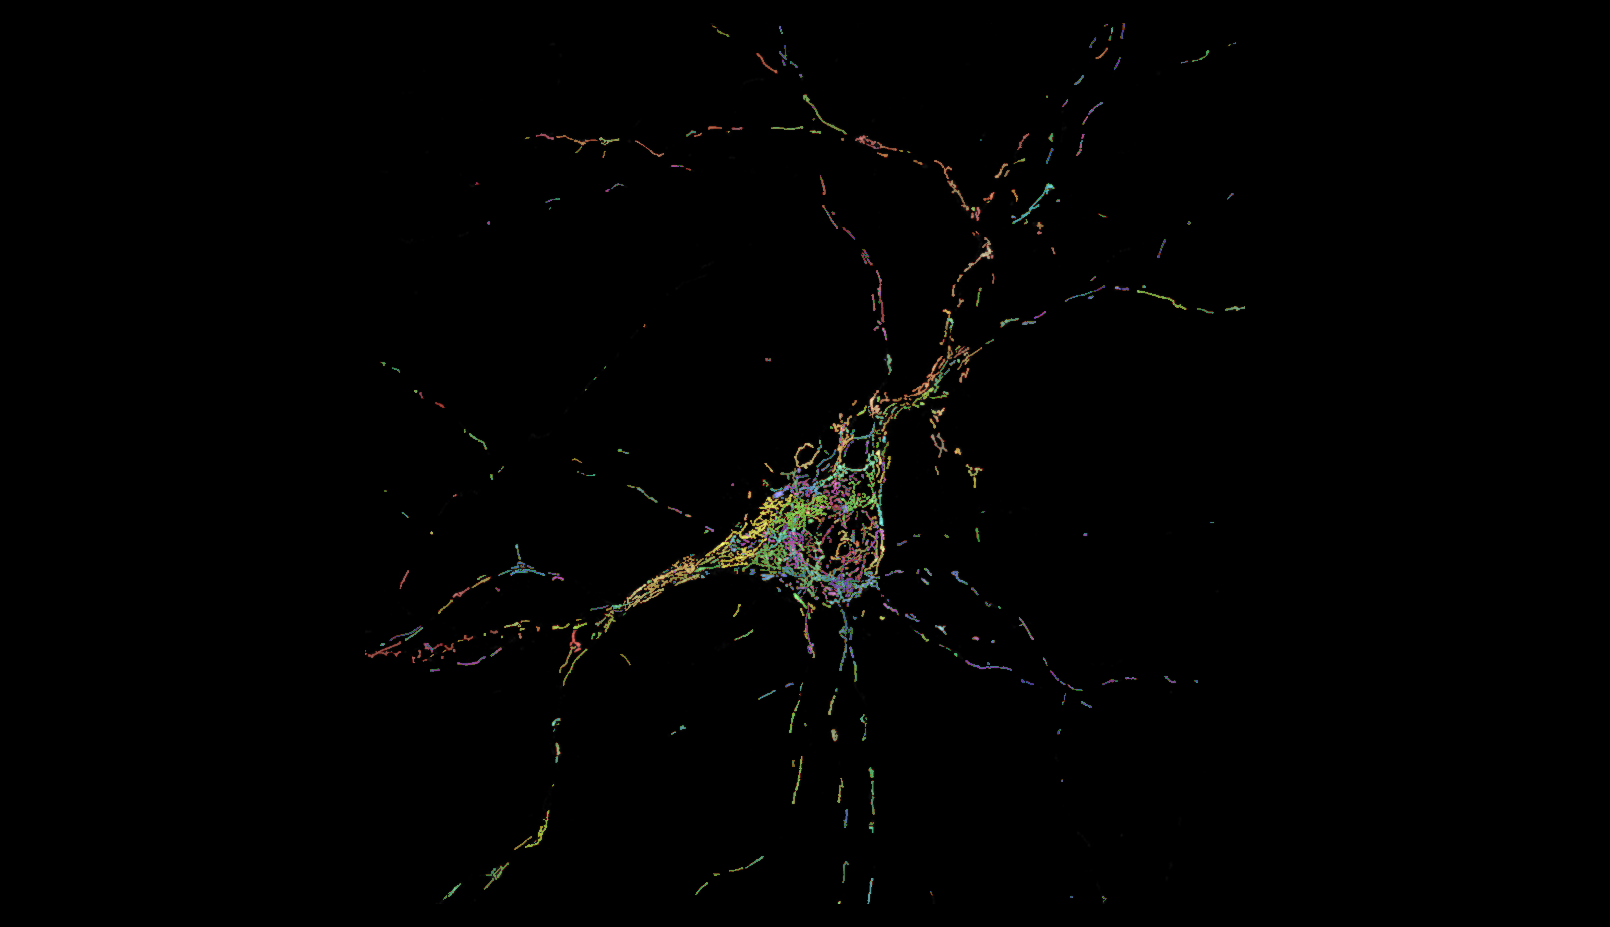

In [ ]:
nbscreenshot(viewer, canvas_only=True)

In [ ]:
viewer.close()

-------------
### NEXT: INFER GOLGI

proceed to [1.4_infer_golgi.ipynb](./1.4_infer_golgi.ipynb)
